In [62]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
import os
from SmilesPE.pretokenizer import atomwise_tokenizer
from os import path as p
import torchtext
from collections import OrderedDict
import math
import torch.nn.functional as tf
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from torch.optim.lr_scheduler import ReduceLROnPlateau
import selfies as sf
from rdkit.Chem import AllChem, Descriptors, Draw
from rdkit import Chem
from rdkit import DataStructs
import seaborn as sns

In [18]:
START_TOKEN = '<start>'
END_TOKEN = '<end>'
PAD_TOKEN = '<pad>'
UNK_TOKEN = '<unk>'
DEVICE = 'cuda:1' if torch.cuda.is_available() else 'cpu'

In [19]:
TOKENS = {'[#Branch1]', '[#Branch2]', '[#C-1]', '[#C]', '[#N+1]', '[#N]', '[=As]', '[=Branch1]', '[=Branch2]', '[=C]', '[=N+1]', '[=N-1]', '[=NH1+1]', '[=NH2+1]', '[=N]', '[=O+1]', '[=O]', '[=P+1]', '[=PH1]', '[=P]', '[=Ring1]', '[=Ring2]', '[=S+1]', '[=SH1]', '[=S]', '[=Se+1]', '[=Se]', '[=Te+1]', '[Al]', '[As]', '[B-1]', '[BH1-1]', '[BH2-1]', '[BH3-1]', '[B]', '[Br]', '[Branch1]', '[Branch2]', '[C+1]', '[C-1]', '[CH1-1]', '[C]', '[Cl+3]', '[Cl]', '[F]', '[H]', '[I+1]', '[I]', '[N+1]', '[N-1]', '[NH1+1]', '[NH1-1]', '[NH1]', '[NH2+1]', '[N]', '[Na]', '[O+1]', '[O-1]', '[OH0]', '[OH1+1]', '[O]', '[P+1]', '[PH1]', '[P]', '[Ring1]', '[Ring2]', '[S+1]', '[S-1]', '[SH1]', '[S]', '[Se+1]', '[SeH1]', '[Se]', '[Si]', '[Te]'}
special_tokens = [PAD_TOKEN, UNK_TOKEN, START_TOKEN, END_TOKEN]
VOCAB = torchtext.vocab.vocab(ordered_dict=OrderedDict({e:1 for e in TOKENS}), specials=special_tokens)
VOCAB.set_default_index(VOCAB[UNK_TOKEN])

In [16]:
# smiles to selfies
in_path = 'denovo_dataset/smiles/enamine.smiles'
out_path = 'denovo_dataset/selfies/enamine.selfies'

with open(in_path, 'r') as in_f:
    break #####################################################
    with open(out_path, 'w') as out_f:
        for l in in_f:
            if 'smile' in l: continue
            
            r = sf.encoder(l.split()[0])
            if r is not None:
                out_f.write(r + '\n')

In [34]:
# Dataset creation
class SelfiesDataset(Dataset):
    def __init__(self, selfies_paths: list, vocab=None, tokens=None, max_len=None): # start and end tokens are added
        '''
        if vocab is None : getVocab() is used
        if max_len is None: take max_len from dataset
        if max_len == 'avg': take average length from dataset
        '''
        if vocab is None: vocab = VOCAB
        self.vocab = vocab

        # reading smiles from files
        tokenized_sen = []
        for file_path in selfies_paths:
            with open(file_path) as f:
                for l in f:
                    tokenized_sen.append(list(sf.split_selfies(l.replace('\n', ''))))

        
        if max_len is None: max_len = max([len(sen) for sen in tokenized_sen])
        if max_len == 'avg': max_len = int(sum([len(sen) for sen in tokenized_sen])/len(tokenized_sen))

        # stripping
        tokenized_sen = [sen[: max_len-2] for sen in tokenized_sen]

        # adding start and end tokens
        tokenized_sen = [[START_TOKEN] + sen + [END_TOKEN] for sen in tokenized_sen]

        # padding
        tokenized_sen = [sen + [PAD_TOKEN]*(max_len-len(sen)) for sen in tokenized_sen]

        # addention mask false at <pad> tokem, true at non pad token
        self.pad_masks = torch.tensor([[PAD_TOKEN==tok for tok in sen] for sen in tokenized_sen])

        # converting to index
        self.data = torch.tensor([self.vocab(sen) for sen in tokenized_sen], dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {'idx': self.data[idx], 'pad_mask': self.pad_masks[idx]}

In [40]:
selfies_path = ['denovo_dataset/selfies/enamine.selfies']
dataset = SelfiesDataset(selfies_path, VOCAB, TOKENS, max_len=100)



In [41]:


# fingureprinting library
library_fps = []
for path in selfies_path:
    with open(path) as f:
        for l in f:
            library_fps.append(generate_morgan_fp(sf.decoder(l.replace('\n', ''))))

In [27]:
len(dataset)

31101

In [28]:
split_ratio = 0.95
split_seed = 42
train_ds, valid_ds = random_split(dataset, [int(len(dataset)*split_ratio), len(dataset)-int(len(dataset)*split_ratio)], generator=torch.Generator().manual_seed(split_seed))

# utils

In [9]:
# Training function
def train(model, optimizer, criterion, train_loader):
    model.train()
    total_loss = 0
    count = 200
    for e in train_loader:
        x = e['idx'].to(DEVICE)
        pad_mask = e['pad_mask'].to(DEVICE)

        x_input = x[:, :-1]
        pad_mask = pad_mask[:, :-1]
        y_expected = x[:, 1:]
        output = model(x_input, pad_mask)
        #print(output.shape, y_expected.shape)

        output = torch.flatten(output, start_dim=0, end_dim=1)
        y_expected = torch.flatten(y_expected, start_dim=0, end_dim=1)
        loss = criterion(output, y_expected)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        count += 1
        #if (count+1)%100 == 0: print(loss.item())
        
    total_loss = total_loss/len(train_loader)
    
    return total_loss

# valid function
def valid(model, criterion, val_loader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for e in val_loader:
            x = e['idx'].to(DEVICE)
            pad_mask = e['pad_mask'].to(DEVICE)

            x_input = x[:, :-1]
            pad_mask = pad_mask[:, :-1]
            y_expected = x[:, 1:]

            output = model(x_input, pad_mask)
            
            output = torch.flatten(output, start_dim=0, end_dim=1)
            y_expected = torch.flatten(y_expected, start_dim=0, end_dim=1)
            loss = criterion(output, y_expected)

            total_loss += loss.item()
        
    total_loss = total_loss/len(val_loader)
   
    return total_loss
    

In [37]:
# generate similarity

def generate_morgan_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=2048)  # Morgan fingerprint radius=2, 1024-bit vector
    return fp

def calculate_tanimoto_similarity(fp1, fp2):
    if fp1 is None or fp2 is None:
        return 0
    similarity = DataStructs.TanimotoSimilarity(fp1, fp2)
    return similarity

In [70]:
def model_similarity(model, num_batch: int, batch_size:int, library_fps, top_k_avg = -1): # -1 take all
    smiles = []
    for i in range(num_batch):
        smiles += model.generateSmiles(batch_size=batch_size, vocab=VOCAB)

    fps = [generate_morgan_fp(s) for s in smiles]

    avgs = []
    maxs = []
    for i in range(len(fps)):
        r = []

        for j in range(len(library_fps)):
            r.append(calculate_tanimoto_similarity(fps[i], library_fps[j]))
        
        r.sort(key=lambda key: -key)
        maxs.append(r[0])
        if top_k_avg == -1: avgs.append(sum(r)/len(r))
        else:
            r = r[0: top_k_avg]
            avgs.append(sum(r)/len(r))


    return maxs, avgs



# model

In [58]:

    
class RNNSelfies(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, num_layers=1, dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(embed_dim, hidden_size, batch_first=True, num_layers=num_layers, dropout=dropout)
        self.linear = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, x, pad_mask=None):
        ''' x = batch * seq_len
            pad_mask = batch*seq_len
        '''
        
        x = self.embedding(x)
        x, _ = self.gru(x)
        x = self.linear(x)
        
        return x

    def getDevice(self):
        ''' return device of model
        '''
        device = next(self.parameters()).device

        if device.index is None:
            return device.type
        else:
            return device.type + ":" + str(device.index) 
    
    def generateSmiles(self, batch_size, vocab, max_len=100):
        x = torch.full((batch_size, 1), vocab[START_TOKEN]).to(self.getDevice())
        
        for i in range(1, max_len+1):
            out = self.forward(x)[:, -1]
            out = tf.softmax(out, dim=1)
            out = torch.multinomial(out, 1)
            x = torch.cat((x, out), dim=1)
        
        x = x.detach().cpu().tolist()
        # converting idx to smiles
        results = []
        for i in range(batch_size):
            sentance = vocab.lookup_tokens(x[i])
            
            new_sentance = [] # removing special chars
            for i in range(1, len(sentance)):
                e = sentance[i]
                if e==END_TOKEN: break
                if e==START_TOKEN or e==PAD_TOKEN or e==UNK_TOKEN:
                    new_sentance = ['invalid']
                    break
                
                new_sentance.append(e)
            
            if new_sentance != 'invalid':
                results.append(sf.decoder(''.join(new_sentance)))
        
        return results
    


In [87]:
model = RNNSelfies(vocab_size=len(VOCAB), 
        embed_dim=256,
        hidden_size=512,
        num_layers=3, 
        dropout=0)

model = model.to(DEVICE)
batch_size = 512

train_loader = DataLoader(train_ds, batch_size)
val_loader = DataLoader(valid_ds, batch_size)

criterion = nn.CrossEntropyLoss(reduction='sum', ignore_index=VOCAB[PAD_TOKEN])
optimizer = optim.Adam(model.parameters(), lr=0.001, amsgrad=True, weight_decay=0.0001)

# learning rate scheduler
scheduler = ReduceLROnPlateau(
    optimizer, mode='min',
    factor=0.5, patience=5,
    cooldown=10, min_lr=0.0001
)

train_result = []
val_result = []
generated_fps = []

In [88]:
for i in range(10):
    tl = train(model, optimizer, criterion, train_loader)/batch_size
    vl = valid(model, criterion, val_loader)/batch_size
    scheduler.step(tl)
    train_result.append(tl)
    val_result.append(vl)

    print("Epoch:", i+1, "train loss:", tl, "val loss:", vl)

generated_fps = model_similarity(model, num_batch=10, batch_size=100, library_fps=library_fps, top_k_avg=100)


Epoch: 1 train loss: 53.67596251389076 val loss: 29.725623697042465
Epoch: 2 train loss: 33.216269262905776 val loss: 22.774177074432373
Epoch: 3 train loss: 27.402842455896838 val loss: 19.890152260661125
Epoch: 4 train loss: 24.624627409310175 val loss: 18.346742004156113
Epoch: 5 train loss: 22.89412646458067 val loss: 17.496974363923073
Epoch: 6 train loss: 21.771436132233717 val loss: 17.128511160612106
Epoch: 7 train loss: 20.973572402164855 val loss: 16.670585811138153
Epoch: 8 train loss: 20.288834522510395 val loss: 16.31344908475876
Epoch: 9 train loss: 19.707785557056294 val loss: 15.96601751446724
Epoch: 10 train loss: 19.23967770872445 val loss: 15.823682382702827


<Axes: ylabel='Density'>

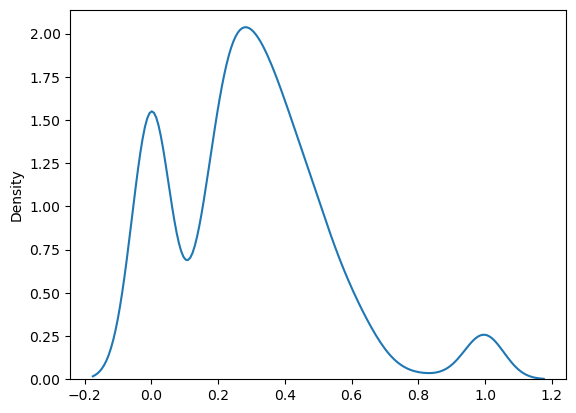

In [89]:
sns.kdeplot(generated_fps[0])

<Axes: ylabel='Density'>

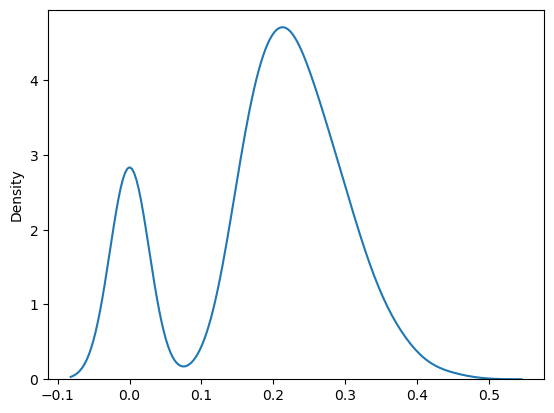

In [77]:
sns.kdeplot(generated_fps[1])

In [91]:
print(generated_fps[0])

[0.4883720930232558, 0.3387096774193548, 0.19402985074626866, 0.4032258064516129, 0.3220338983050847, 0.0, 0.3076923076923077, 0.25757575757575757, 0.0, 0.4567901234567901, 0.5, 0.2, 0.0, 0.15126050420168066, 0.2345679012345679, 0.36507936507936506, 0.5925925925925926, 0.543859649122807, 0.2127659574468085, 0.38095238095238093, 0.325, 0.5405405405405406, 0.0, 0.18181818181818182, 0.2976190476190476, 0.375, 1.0, 0.13513513513513514, 0.5135135135135135, 0.3389830508474576, 0.3050847457627119, 1.0, 0.44680851063829785, 0.0, 0.421875, 0.0, 0.16923076923076924, 0.3389830508474576, 0.4482758620689655, 0.36363636363636365, 0.5925925925925926, 0.3902439024390244, 0.0, 0.59375, 0.8604651162790697, 0.0, 0.0, 0.21739130434782608, 0.4727272727272727, 0.3373493975903614, 0.3142857142857143, 0.0, 0.25396825396825395, 0.37894736842105264, 0.0, 0.0, 0.0, 0.0, 0.37777777777777777, 0.425, 1.0, 0.5128205128205128, 0.3170731707317073, 0.0, 0.43478260869565216, 1.0, 0.5079365079365079, 0.24, 0.163934426229

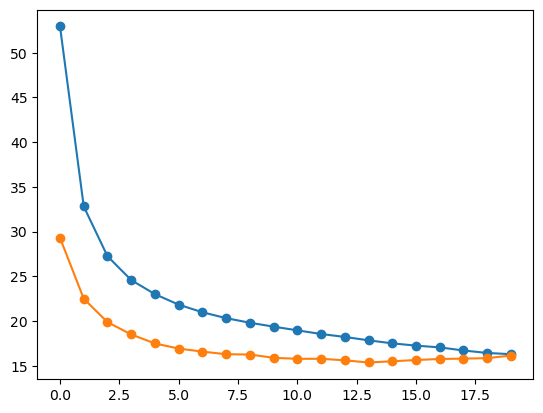

In [35]:
plt.plot(train_result, marker='o')
plt.plot(val_result, marker='o')

In [72]:
smiles = model.generateSmiles(batch_size=100, vocab=VOCAB)

for e in smiles:
    smile = "".join(e)
    print(sf.decoder(smile))
    

COC=CC=C(C1=CN=CC=C1CCCN2C(=O)C3=CC=CC=C32)CCl
COC=CCC=CC1=C(NNC(=O)C=C2C3=C(Cl)C=CC=N3)N=CCCCC=CC=C2C=N1
O=CCOC1CCNC=C1CCS(=O)(=O)C=CC2C3=CC=CC=C3CCC2C=CC=CS
C1=2C(CC(=O)C(C)CNC=O)C=C1C=2C=NCC
CCCCCC1=NC(N)C(=C)C1(C(=O)OCCCOC=CC=C(O)C=N)CCCC2=CC=CC=C2S
COC=C1C=CCNC(=O)NCC(=O)C=CC1(NNCC(=O)[NH1]C)CCC(=O)NCCNCC2CC(C)CC2
CC1C(OC)C=CC1C#N
O=C(CNC(=O)C(C)CCC(C)CC1C2)C(O)C=CC(Br)=C2NCNC=CC=CC(=O)OCC=C(F)C(F)=C1CC(F)C
N=C(S)C=O
C1OC=CC=C2CNOC2(CSCC=C1C3)CC(C)CC3CC=O
O=CC1(O)C=CC=C1C(=O)CC[NH1]N=C(C2=CC=CC=C2)NN=CC=C3CC4=CC=CC=C4C=N3
CS(=O)(=C)C=C(C(C12CC=CC(=C1)C)=CC=CC3=CC=CC=C3C(C4=CC=CC=C4CC2CCC)C)CC=O
N#CC=CC=CNC=CC=C(C)Cl
C1C=NN=C(C=O)CCCC=C1
CC(C)CC(C(=O)N1CC2C3SC(=O)NC=NC=CC=C(Cl)C)=C3N2C=C(OS)C1=C
CCCCCCCCNC(=O)CCOCCOCC=CS(=O)(=O)C1=CC=CC=C1CCCCNC=N
CC(C)CC(CCC1CCCC=C1N)C=C(C)CC2=CC=CC=C2[N+1](=O)[O-1]
CCN(C#N)C=C1C=CC=C1N2CC=CC=C(C3)N23
CC(C)CCNCC=C1C(=O)ONC2=C(CN=C2NC=C)C=C1[NH1]C=C=CC=CC=C
CC(=O)C1=CC=C2C=C1NC(=O)C=CC=C(O3)C2C=CC=C3
COCC=CC(C(=O)N)C(C)CCCCC(N)=O
CC=CCCC1CNC(=O)CC1

In [110]:
generated_fps[1][:20]

[0.27279163774707527,
 0.24045249868090773,
 0.16521803818767922,
 0.2284536704932533,
 0.21441295628900406,
 0.0,
 0.2774930154352177,
 0.18231653130952133,
 0.0,
 0.3763171797227283,
 0.2583433503127924,
 0.16822665174588533,
 0.0,
 0.13725145433273858,
 0.15227686519156852,
 0.22595270096920964,
 0.3073996058978393,
 0.3086297184013883,
 0.1420894269546874,
 0.23592148533782825]

In [95]:
rnn = [0.4883720930232558, 0.3387096774193548, 0.19402985074626866, 0.4032258064516129, 0.3220338983050847, 0.0, 0.3076923076923077, 0.25757575757575757, 0.0, 0.4567901234567901, 0.5, 0.2, 0.0, 0.15126050420168066, 0.2345679012345679, 0.36507936507936506, 0.5925925925925926, 0.543859649122807, 0.2127659574468085, 0.38095238095238093, 0.325, 0.5405405405405406, 0.0, 0.18181818181818182, 0.2976190476190476, 0.375, 1.0, 0.13513513513513514, 0.5135135135135135, 0.3389830508474576, 0.3050847457627119, 1.0, 0.44680851063829785, 0.0, 0.421875, 0.0, 0.16923076923076924, 0.3389830508474576, 0.4482758620689655, 0.36363636363636365, 0.5925925925925926, 0.3902439024390244, 0.0, 0.59375, 0.8604651162790697, 0.0, 0.0, 0.21739130434782608, 0.4727272727272727, 0.3373493975903614, 0.3142857142857143, 0.0, 0.25396825396825395, 0.37894736842105264, 0.0, 0.0, 0.0, 0.0, 0.37777777777777777, 0.425, 1.0, 0.5128205128205128, 0.3170731707317073, 0.0, 0.43478260869565216, 1.0, 0.5079365079365079, 0.24, 0.16393442622950818, 0.30612244897959184, 0.4, 0.0, 0.2465753424657534, 0.575, 0.0, 0.0, 1.0, 0.5897435897435898, 0.4, 0.15517241379310345, 0.4444444444444444, 0.6349206349206349, 0.3548387096774194, 1.0, 0.5915492957746479, 0.7317073170731707, 0.9743589743589743, 1.0, 0.27586206896551724, 0.3076923076923077, 0.3013698630136986, 0.17073170731707318, 0.0, 0.0, 0.0, 0.24324324324324326, 0.36585365853658536, 0.36486486486486486, 0.9714285714285714, 0.3956043956043956, 0.41333333333333333, 0.23076923076923078, 0.27631578947368424, 0.3709677419354839, 0.2692307692307692, 0.5223880597014925, 0.3409090909090909, 0.6, 0.0, 0.2962962962962963, 0.0, 0.0, 0.0, 0.14925373134328357, 0.3559322033898305, 0.30434782608695654, 0.18181818181818182, 0.0, 0.2328767123287671, 0.19491525423728814, 0.4523809523809524, 0.25, 0.26666666666666666, 0.2523364485981308, 0.2835820895522388, 0.24, 0.24390243902439024, 0.5333333333333333, 0.0, 0.0, 0.2698412698412698, 0.2625, 0.21428571428571427, 0.15584415584415584, 0.3870967741935484, 0.0, 0.175, 0.2289156626506024, 0.0, 0.0, 0.3283582089552239, 0.23214285714285715, 0.36065573770491804, 0.5, 0.2336448598130841, 0.0, 0.25, 0.25, 0.32894736842105265, 0.5, 0.46551724137931033, 0.0, 0.5056179775280899, 0.2857142857142857, 0.0, 0.29411764705882354, 0.0, 0.2755102040816326, 0.3013698630136986, 0.2857142857142857, 0.375, 0.3, 0.40298507462686567, 0.0, 0.0, 0.43243243243243246, 0.34285714285714286, 0.0, 0.0, 0.25252525252525254, 0.47368421052631576, 0.0, 0.171875, 0.0, 1.0, 0.0, 0.5245901639344263, 0.6724137931034483, 0.5490196078431373, 0.2962962962962963, 0.24444444444444444, 0.0, 0.0, 0.3333333333333333, 0.22448979591836735, 0.26, 0.46511627906976744, 0.47368421052631576, 0.42857142857142855, 0.43157894736842106, 0.2911392405063291, 0.3829787234042553, 0.0, 0.42105263157894735, 1.0, 0.32926829268292684, 0.0, 0.1935483870967742, 0.26582278481012656, 0.0, 0.0, 0.3793103448275862, 0.3829787234042553, 0.30434782608695654, 0.0, 0.0, 0.23376623376623376, 0.43243243243243246, 0.4473684210526316, 0.36507936507936506, 0.3170731707317073, 0.34146341463414637, 0.21238938053097345, 0.14285714285714285, 0.3783783783783784, 0.0, 0.47058823529411764, 0.375, 0.0, 0.16666666666666666, 0.0, 0.22972972972972974, 1.0, 0.0, 0.38571428571428573, 0.3137254901960784, 0.3269230769230769, 0.3194444444444444, 0.1834862385321101, 0.48214285714285715, 0.2815533980582524, 0.0, 0.43137254901960786, 0.3076923076923077, 0.5853658536585366, 0.4117647058823529, 0.46, 0.32, 0.23943661971830985, 0.26136363636363635, 0.0, 0.5581395348837209, 0.6388888888888888, 0.1485148514851485, 0.42857142857142855, 0.417910447761194, 0.0, 0.2631578947368421, 0.2982456140350877, 0.2028985507246377, 0.0, 0.38461538461538464, 0.0, 1.0, 0.6285714285714286, 0.24468085106382978, 0.6507936507936508, 0.375, 0.3333333333333333, 0.5606060606060606, 0.0, 0.4782608695652174, 0.21212121212121213, 0.2727272727272727, 0.0, 0.28846153846153844, 0.0, 0.4117647058823529, 0.22058823529411764, 1.0, 0.203125, 0.24324324324324326, 0.3448275862068966, 0.22429906542056074, 0.0, 0.3611111111111111, 0.32432432432432434, 0.0, 0.2830188679245283, 0.2717391304347826, 0.29508196721311475, 0.0, 0.6111111111111112, 0.0, 0.2676056338028169, 0.2857142857142857, 0.0, 0.49019607843137253, 0.39436619718309857, 0.3448275862068966, 0.26595744680851063, 0.3783783783783784, 0.543859649122807, 0.17307692307692307, 0.18333333333333332, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.1891891891891892, 0.19148936170212766, 0.1917808219178082, 0.5909090909090909, 0.4166666666666667, 0.3235294117647059, 0.0, 0.43283582089552236, 0.5333333333333333, 0.4, 0.2112676056338028, 0.23809523809523808, 0.296875, 0.0, 0.14814814814814814, 0.4166666666666667, 0.1927710843373494, 0.29545454545454547, 0.265625, 0.27419354838709675, 0.25333333333333335, 0.2876712328767123, 0.35714285714285715, 0.24615384615384617, 0.18627450980392157, 0.0, 0.4888888888888889, 0.47058823529411764, 0.0, 0.5454545454545454, 0.20481927710843373, 0.18571428571428572, 0.17543859649122806, 0.48484848484848486, 0.44, 0.44329896907216493, 0.6122448979591837, 0.19642857142857142, 0.32432432432432434, 0.0, 0.4583333333333333, 0.0, 0.5476190476190477, 0.9629629629629629, 0.29577464788732394, 0.5, 0.0, 0.20967741935483872, 0.34545454545454546, 0.21739130434782608, 0.2982456140350877, 0.2948717948717949, 0.6571428571428571, 0.4444444444444444, 0.972972972972973, 0.22033898305084745, 0.0, 0.37209302325581395, 0.21794871794871795, 0.2653061224489796, 0.0, 0.2692307692307692, 0.0, 0.0, 0.0, 0.4074074074074074, 0.3698630136986301, 0.6388888888888888, 0.30158730158730157, 0.27450980392156865, 0.323943661971831, 0.22448979591836735, 0.30434782608695654, 0.4634146341463415, 0.2903225806451613, 0.0, 0.40350877192982454, 0.25, 0.5606060606060606, 0.25301204819277107, 0.24444444444444444, 0.5111111111111111, 0.5, 0.35294117647058826, 0.36619718309859156, 0.0, 0.2727272727272727, 0.0, 0.34615384615384615, 0.46511627906976744, 0.41379310344827586, 0.48148148148148145, 0.627906976744186, 0.38571428571428573, 0.20634920634920634, 0.0, 0.42105263157894735, 0.5245901639344263, 0.0, 0.2153846153846154, 0.3137254901960784, 0.0, 0.41935483870967744, 0.0, 0.19047619047619047, 0.2, 0.38461538461538464, 0.0, 1.0, 0.0, 0.34615384615384615, 0.46551724137931033, 0.22972972972972974, 0.28888888888888886, 0.5357142857142857, 0.0, 0.0, 0.36363636363636365, 0.2261904761904762, 0.52, 0.24675324675324675, 0.0, 0.19718309859154928, 0.1320754716981132, 0.328125, 0.22388059701492538, 0.18666666666666668, 0.4, 0.14516129032258066, 0.35185185185185186, 0.2926829268292683, 0.2, 0.3877551020408163, 0.4897959183673469, 0.3382352941176471, 0.0, 0.30303030303030304, 0.4117647058823529, 0.2743362831858407, 0.3488372093023256, 0.0, 0.373134328358209, 0.35185185185185186, 0.34782608695652173, 0.34375, 0.16666666666666666, 0.0, 0.2564102564102564, 0.23863636363636365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.32, 0.0, 0.54, 0.21428571428571427, 0.0, 0.2, 0.4838709677419355, 0.43333333333333335, 0.29411764705882354, 0.3561643835616438, 0.19047619047619047, 0.40350877192982454, 0.2692307692307692, 0.0, 0.18548387096774194, 0.49122807017543857, 0.55, 0.4423076923076923, 0.0, 0.20238095238095238, 0.19696969696969696, 0.33766233766233766, 0.19047619047619047, 0.3275862068965517, 0.0, 0.3253012048192771, 1.0, 0.2112676056338028, 0.18867924528301888, 0.45454545454545453, 0.18032786885245902, 0.5178571428571429, 0.0, 0.6060606060606061, 0.0, 0.23943661971830985, 0.0, 0.2, 0.2558139534883721, 0.2647058823529412, 0.5121951219512195, 0.3142857142857143, 0.5081967213114754, 0.14925373134328357, 0.0, 0.52, 0.19736842105263158, 0.24390243902439024, 0.0, 0.31645569620253167, 0.4, 0.36619718309859156, 0.2692307692307692, 0.0, 0.0, 0.0, 0.4533333333333333, 0.16470588235294117, 0.29411764705882354, 1.0, 0.2727272727272727, 0.0, 0.575, 0.39705882352941174, 0.3939393939393939, 0.0, 0.5833333333333334, 0.4583333333333333, 0.0, 0.0, 0.4727272727272727, 0.26, 0.32142857142857145, 0.3114754098360656, 0.26666666666666666, 0.525, 0.3333333333333333, 0.2318840579710145, 0.4098360655737705, 0.22641509433962265, 0.234375, 0.2926829268292683, 0.5454545454545454, 0.16923076923076924, 0.2125, 0.36363636363636365, 0.38095238095238093, 0.0, 0.0, 0.23333333333333334, 1.0, 0.3469387755102041, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.2391304347826087, 0.23076923076923078, 0.43902439024390244, 0.29850746268656714, 0.32653061224489793, 0.2698412698412698, 0.43859649122807015, 0.2982456140350877, 0.5272727272727272, 0.24242424242424243, 0.42105263157894735, 0.34, 0.0, 0.6219512195121951, 0.19230769230769232, 0.2647058823529412, 0.6363636363636364, 0.2073170731707317, 0.3333333333333333, 0.21212121212121213, 0.2619047619047619, 0.5192307692307693, 0.0, 0.0, 0.6590909090909091, 0.23655913978494625, 0.17391304347826086, 0.7575757575757576, 0.3888888888888889, 0.0, 0.3333333333333333, 0.5777777777777777, 0.36363636363636365, 0.37349397590361444, 0.0, 0.22033898305084745, 0.46, 0.23333333333333334, 0.0, 0.48333333333333334, 0.0, 0.0, 0.3804347826086957, 0.47540983606557374, 0.0, 0.0, 0.0, 0.22972972972972974, 0.5416666666666666, 0.3116883116883117, 0.38461538461538464, 0.28378378378378377, 0.4418604651162791, 0.5294117647058824, 0.6, 0.6031746031746031, 0.2916666666666667, 0.3181818181818182, 0.5, 0.3333333333333333, 1.0, 0.0, 0.23333333333333334, 0.19298245614035087, 0.3389830508474576, 0.0, 0.15714285714285714, 0.19444444444444445, 0.22727272727272727, 0.5849056603773585, 0.20512820512820512, 0.4857142857142857, 0.0, 0.3333333333333333, 0.0, 1.0, 0.24489795918367346, 0.26153846153846155, 0.19696969696969696, 0.41935483870967744, 0.0, 0.0, 0.0, 0.6842105263157895, 0.6938775510204082, 0.0, 0.38823529411764707, 0.3333333333333333, 0.34615384615384615, 0.0, 0.24390243902439024, 0.13559322033898305, 0.26785714285714285, 0.3493975903614458, 0.265625, 0.20202020202020202, 0.35294117647058826, 0.0, 0.0, 0.37777777777777777, 0.1267605633802817, 0.45263157894736844, 0.5531914893617021, 1.0, 0.24074074074074073, 0.1724137931034483, 0.0, 0.0, 0.17647058823529413, 0.5084745762711864, 0.23809523809523808, 0.0, 0.3902439024390244, 0.2028985507246377, 0.4918032786885246, 0.0, 0.3173076923076923, 0.38181818181818183, 0.36923076923076925, 0.5217391304347826, 0.5416666666666666, 0.3333333333333333, 0.23376623376623376, 0.3492063492063492, 0.20967741935483872, 0.2777777777777778, 0.0, 0.2, 0.4339622641509434, 1.0, 0.18, 0.3875, 0.0, 0.0, 0.0, 0.6129032258064516, 0.44, 0.390625, 0.3389830508474576, 0.0, 0.3076923076923077, 1.0, 0.2891566265060241, 0.8, 0.5172413793103449, 1.0, 0.0, 0.4461538461538462, 0.1935483870967742, 0.30434782608695654, 0.2948717948717949, 0.25, 0.27956989247311825, 0.0, 0.5263157894736842, 0.0, 0.3333333333333333, 0.0, 0.18556701030927836, 0.6410256410256411, 0.0, 0.4444444444444444, 0.0, 0.3076923076923077, 0.20967741935483872, 0.2127659574468085, 0.6097560975609756, 0.234375, 0.0, 1.0, 0.2698412698412698, 0.0, 0.1875, 0.36065573770491804, 0.0, 0.0, 0.0, 0.6833333333333333, 0.31666666666666665, 0.0, 0.0, 0.0, 0.3492063492063492, 0.16363636363636364, 0.0, 0.3181818181818182, 0.6216216216216216, 0.2682926829268293, 0.0, 0.4444444444444444, 0.0, 0.22413793103448276, 0.0, 0.5853658536585366, 0.6949152542372882, 0.323943661971831, 0.3333333333333333, 0.2, 0.34146341463414637, 0.3235294117647059, 0.3707865168539326, 0.0, 0.20833333333333334, 0.18571428571428572, 0.0, 0.44680851063829785, 0.30337078651685395, 0.0, 0.42105263157894735, 0.47058823529411764, 0.46153846153846156, 0.0, 0.0, 0.8947368421052632, 0.2647058823529412, 0.8108108108108109, 0.0, 0.22, 0.4722222222222222, 0.47368421052631576, 1.0, 0.0, 0.0, 0.29310344827586204, 1.0, 0.0, 0.25, 0.24074074074074073, 0.5342465753424658, 1.0, 0.0, 0.2987012987012987, 0.40476190476190477, 0.43478260869565216, 1.0, 0.0, 0.0, 0.0, 0.0, 0.4222222222222222, 0.0, 0.21212121212121213, 0.2702702702702703, 0.42105263157894735, 0.20512820512820512, 0.5714285714285714, 0.509090909090909, 0.625, 1.0, 0.4489795918367347, 0.22058823529411764, 0.3090909090909091, 0.2535211267605634, 0.6181818181818182, 0.24324324324324326, 0.17857142857142858, 0.0, 0.37037037037037035, 0.4107142857142857, 0.0, 0.5, 0.42592592592592593, 0.0, 0.35443037974683544, 0.3287671232876712, 0.23636363636363636, 0.425531914893617, 0.2391304347826087, 0.0, 0.18604651162790697, 0.3157894736842105, 0.0, 0.37681159420289856, 0.37, 0.33663366336633666, 0.0, 0.25, 0.42857142857142855, 0.0, 0.0, 0.25862068965517243, 0.41818181818181815, 0.0, 0.2696629213483146, 0.5428571428571428, 0.24285714285714285, 0.2028985507246377, 0.49122807017543857, 0.4, 0.32075471698113206, 0.24509803921568626, 0.5, 1.0, 0.4339622641509434, 0.0, 0.42857142857142855, 0.0, 0.4024390243902439, 0.28378378378378377, 0.24, 0.38961038961038963, 0.0, 0.2765957446808511, 0.4098360655737705, 0.2988505747126437, 0.6666666666666666, 0.26506024096385544, 0.17142857142857143, 0.5806451612903226, 0.38596491228070173, 0.0, 0.3181818181818182, 0.3448275862068966, 1.0, 0.4, 0.391304347826087, 1.0, 0.0, 0.4166666666666667, 0.34782608695652173, 0.5, 0.2111111111111111, 0.14754098360655737, 0.6122448979591837, 0.3793103448275862, 0.24390243902439024, 0.45454545454545453, 0.16417910447761194, 0.16666666666666666, 0.4318181818181818, 0.0, 0.5476190476190477, 0.39215686274509803, 0.3448275862068966, 0.4444444444444444, 0.35365853658536583, 0.2972972972972973, 0.2459016393442623, 0.2597402597402597, 0.4772727272727273, 0.0, 0.0, 0.4634146341463415, 0.0, 0.22950819672131148, 0.4166666666666667, 0.5, 0.43137254901960786, 0.24615384615384617, 0.34375, 0.7027027027027027, 0.5102040816326531, 0.5, 0.2857142857142857, 0.32098765432098764, 0.3333333333333333, 0.0, 0.2777777777777778, 0.34615384615384615, 0.45714285714285713, 0.4, 0.5866666666666667, 0.6212121212121212, 0.6451612903225806, 0.19117647058823528, 0.13846153846153847, 0.0, 0.6363636363636364, 0.175, 0.5283018867924528, 0.3176470588235294, 0.0, 0.23728813559322035, 0.0, 0.0, 0.2753623188405797, 0.10606060606060606, 0.42857142857142855, 0.19753086419753085, 0.20689655172413793, 0.47692307692307695, 0.27631578947368424, 0.225, 0.36363636363636365, 0.2391304347826087, 0.22641509433962265, 0.29850746268656714, 0.0, 0.56, 0.47540983606557374, 0.25, 0.21153846153846154, 0.3548387096774194, 1.0, 0.2535211267605634, 0.17857142857142858, 0.0, 0.25742574257425743, 0.0, 0.0, 0.23076923076923078, 0.35384615384615387, 0.5487804878048781, 0.46808510638297873, 0.2222222222222222, 0.0, 0.18518518518518517, 0.25396825396825395, 0.20833333333333334, 0.0, 0.36363636363636365, 0.35714285714285715, 0.58, 0.5277777777777778, 0.43636363636363634, 0.3076923076923077, 0.32098765432098764, 0.4025974025974026, 0.40476190476190477, 0.0, 0.0, 0.2786885245901639, 0.4838709677419355, 0.0, 0.3877551020408163, 0.2535211267605634, 0.5151515151515151, 0.5208333333333334, 0.2222222222222222, 0.2909090909090909, 0.6530612244897959, 0.19607843137254902, 0.38571428571428573, 0.3404255319148936, 0.38461538461538464, 0.34375, 0.5641025641025641, 0.5070422535211268, 0.4857142857142857, 1.0, 0.4583333333333333, 0.0, 0.4634146341463415, 0.4423076923076923, 0.20833333333333334, 0.0, 0.0, 0.7021276595744681]


In [96]:
trains = [0.42857142857142855, 0.23170731707317074, 0.18032786885245902, 0.2857142857142857, 0.3076923076923077, 0.2736842105263158, 0.14473684210526316, 0.0, 0.2962962962962963, 0.16, 1.0, 0.3333333333333333, 0.275, 0.0, 0.3283582089552239, 0.30158730158730157, 0.30952380952380953, 0.3, 0.0, 0.21739130434782608, 0.3088235294117647, 0.1951219512195122, 0.2909090909090909, 0.20833333333333334, 0.15873015873015872, 0.48936170212765956, 0.4146341463414634, 0.43333333333333335, 0.20588235294117646, 0.0, 0.4, 0.0, 1.0, 0.1917808219178082, 0.1724137931034483, 0.1518987341772152, 0.5384615384615384, 0.2711864406779661, 0.37142857142857144, 0.20238095238095238, 0.30158730158730157, 0.48936170212765956, 0.5151515151515151, 0.20987654320987653, 0.0, 0.40476190476190477, 0.3877551020408163, 0.20833333333333334, 0.1728395061728395, 0.45454545454545453, 0.0, 0.0, 0.25333333333333335, 0.1791044776119403, 0.0, 0.28378378378378377, 1.0, 0.0, 0.27586206896551724, 0.42105263157894735, 0.0, 0.2077922077922078, 0.36538461538461536, 0.19718309859154928, 0.4166666666666667, 0.0, 0.0, 0.3333333333333333, 0.23529411764705882, 0.3333333333333333, 0.36538461538461536, 0.0, 0.2692307692307692, 0.21052631578947367, 0.3170731707317073, 0.6206896551724138, 0.0, 0.18333333333333332, 0.288135593220339, 0.5, 0.0, 0.28421052631578947, 0.22413793103448276, 0.29411764705882354, 0.189873417721519, 0.2077922077922078, 0.49056603773584906, 0.0, 0.21568627450980393, 0.1782178217821782, 0.19298245614035087, 0.2564102564102564, 0.23636363636363636, 0.24, 0.1891891891891892, 0.18, 1.0, 0.0, 0.34782608695652173, 0.2222222222222222, 0.5555555555555556, 0.18840579710144928, 0.3235294117647059, 0.38596491228070173, 0.0, 0.0, 0.0, 0.20754716981132076, 0.13793103448275862, 0.18032786885245902, 0.30612244897959184, 0.0, 0.1791044776119403, 0.0, 0.6170212765957447, 0.27586206896551724, 0.4375, 0.46511627906976744, 0.0, 0.21666666666666667, 0.2923076923076923, 0.0, 0.0, 0.3076923076923077, 0.1694915254237288, 0.32857142857142857, 0.3958333333333333, 0.34285714285714286, 0.0, 0.3898305084745763, 0.40816326530612246, 0.2247191011235955, 0.3389830508474576, 0.26229508196721313, 0.2857142857142857, 0.0, 0.0, 0.323943661971831, 0.2222222222222222, 0.2702702702702703, 0.0, 0.18421052631578946, 0.2641509433962264, 0.0, 0.1791044776119403, 0.16666666666666666, 0.0, 0.15151515151515152, 0.0, 0.0, 0.3684210526315789, 0.23728813559322035, 0.39215686274509803, 0.21568627450980393, 0.0, 0.21428571428571427, 0.0, 0.24528301886792453, 0.4225352112676056, 0.15625, 0.0, 0.0, 0.2777777777777778, 0.27906976744186046, 0.3220338983050847, 0.4166666666666667, 0.3582089552238806, 0.3617021276595745, 0.45098039215686275, 0.18181818181818182, 0.0, 0.0, 0.4727272727272727, 1.0, 0.24242424242424243, 0.15384615384615385, 0.4791666666666667, 0.2549019607843137, 0.18518518518518517, 0.6111111111111112, 0.717391304347826, 0.2375, 0.2077922077922078, 1.0, 1.0, 0.3404255319148936, 0.0, 0.38028169014084506, 0.35714285714285715, 0.36363636363636365, 0.0, 0.5128205128205128, 0.14516129032258066, 0.40816326530612246, 0.5789473684210527, 0.0, 0.5853658536585366, 0.32608695652173914, 0.5645161290322581, 0.0, 0.0, 0.2558139534883721, 0.4, 0.2222222222222222, 0.2222222222222222, 0.171875, 0.4074074074074074, 0.2537313432835821, 0.323943661971831, 0.2191780821917808, 0.25, 0.0, 0.28846153846153844, 0.24752475247524752, 0.2987012987012987, 0.3684210526315789, 0.0, 0.36065573770491804, 0.47619047619047616, 0.3088235294117647, 1.0, 0.43902439024390244, 0.3333333333333333, 0.2833333333333333, 0.40384615384615385, 0.45454545454545453, 0.24390243902439024, 0.36, 0.15384615384615385, 0.44, 0.25, 0.0, 0.0, 0.3114754098360656, 0.3, 0.22857142857142856, 0.16279069767441862, 0.22641509433962265, 0.46551724137931033, 0.18461538461538463, 0.375, 0.0, 0.375, 0.5636363636363636, 0.21428571428571427, 0.24050632911392406, 0.2978723404255319, 0.26666666666666666, 0.20512820512820512, 0.2545454545454545, 0.0, 0.0, 0.4523809523809524, 0.0, 0.1935483870967742, 0.6285714285714286, 0.1650485436893204, 0.2608695652173913, 0.35714285714285715, 0.3194444444444444, 0.17391304347826086, 0.24193548387096775, 0.0, 0.35185185185185186, 0.0, 0.6111111111111112, 0.3829787234042553, 0.4318181818181818, 0.3191489361702128, 0.0, 0.37777777777777777, 0.4166666666666667, 0.34177215189873417, 0.36363636363636365, 0.15, 0.34, 0.0, 0.2345679012345679, 0.0, 0.11864406779661017, 0.35185185185185186, 0.40816326530612246, 0.0, 0.2875, 0.41818181818181815, 0.0, 1.0, 0.4, 0.26136363636363635, 0.22727272727272727, 0.21052631578947367, 0.3898305084745763, 0.2602739726027397, 0.3787878787878788, 0.0, 1.0, 0.0, 0.15555555555555556, 0.0, 0.44642857142857145, 0.2608695652173913, 0.21818181818181817, 0.3, 0.4318181818181818, 0.40625, 0.3269230769230769, 0.26666666666666666, 0.0, 0.3617021276595745, 0.0, 0.323943661971831, 0.20987654320987653, 0.35714285714285715, 0.3103448275862069, 0.3958333333333333, 0.18181818181818182, 0.0, 0.23376623376623376, 0.21875, 0.20408163265306123, 0.21052631578947367, 0.24050632911392406, 0.45454545454545453, 0.7333333333333333, 0.375, 0.2, 0.19480519480519481, 0.20754716981132076, 0.0, 0.0, 0.40350877192982454, 0.36, 0.0, 0.16216216216216217, 0.0, 0.18181818181818182, 0.37735849056603776, 0.47619047619047616, 0.0, 0.23333333333333334, 0.0, 0.0, 0.0, 0.3620689655172414, 0.43636363636363634, 0.2222222222222222, 0.3472222222222222, 0.3333333333333333, 0.2236842105263158, 0.41025641025641024, 0.15555555555555556, 0.1875, 0.3, 0.0, 0.21505376344086022, 0.3469387755102041, 0.3333333333333333, 0.19642857142857142, 0.4666666666666667, 0.27906976744186046, 0.21505376344086022, 0.0, 0.15853658536585366, 0.1891891891891892, 0.5476190476190477, 0.20930232558139536, 0.2112676056338028, 1.0, 0.0, 1.0, 0.20689655172413793, 0.3409090909090909, 0.22058823529411764, 0.23404255319148937, 0.0, 0.30434782608695654, 0.0, 0.0, 0.14285714285714285, 0.2978723404255319, 0.36, 0.2857142857142857, 0.4838709677419355, 0.4406779661016949, 1.0, 0.575, 0.0, 0.5306122448979592, 0.19736842105263158, 0.34210526315789475, 0.19230769230769232, 0.6458333333333334, 0.2549019607843137, 0.0, 0.313953488372093, 0.43333333333333335, 0.0, 0.48484848484848486, 0.18518518518518517, 0.3870967741935484, 0.2857142857142857, 0.2676056338028169, 0.2698412698412698, 0.2978723404255319, 0.0, 0.4, 0.6666666666666666, 0.49056603773584906, 0.2558139534883721, 0.0, 0.3103448275862069, 0.29577464788732394, 0.4166666666666667, 0.28431372549019607, 0.22, 0.0, 0.23333333333333334, 0.0, 0.23809523809523808, 0.0, 0.2916666666666667, 0.0, 0.4186046511627907, 0.34, 0.34146341463414637, 0.2553191489361702, 0.0, 0.1791044776119403, 0.0, 0.0, 0.0, 0.22857142857142856, 0.0, 0.0, 0.4827586206896552, 0.23636363636363636, 0.3793103448275862, 0.48148148148148145, 0.2807017543859649, 0.3424657534246575, 0.14473684210526316, 0.26666666666666666, 0.5, 0.1702127659574468, 0.0, 0.0, 0.23529411764705882, 0.41304347826086957, 0.48, 0.0, 0.3469387755102041, 0.21428571428571427, 0.4897959183673469, 0.34285714285714286, 1.0, 0.22727272727272727, 0.25925925925925924, 0.425531914893617, 0.15853658536585366, 0.19117647058823528, 0.42857142857142855, 0.2653061224489796, 0.40963855421686746, 0.2391304347826087, 0.2857142857142857, 0.37777777777777777, 0.0, 0.31666666666666665, 0.3584905660377358, 0.32653061224489793, 0.2222222222222222, 0.35384615384615387, 0.0, 0.2463768115942029, 0.32558139534883723, 0.5681818181818182, 0.3442622950819672, 0.20833333333333334, 0.0, 0.0, 0.15942028985507245, 0.21839080459770116, 0.0, 0.4594594594594595, 0.12857142857142856, 0.18666666666666668, 0.20588235294117646, 0.2608695652173913, 0.6388888888888888, 0.3787878787878788, 0.0, 0.25925925925925924, 0.32142857142857145, 0.0, 0.3114754098360656, 0.15217391304347827, 0.0, 0.631578947368421, 0.6, 0.2702702702702703, 0.2222222222222222, 0.0, 0.19696969696969696, 0.3492063492063492, 0.0, 0.4489795918367347, 0.19672131147540983, 0.8787878787878788, 0.2804878048780488, 0.3424657534246575, 0.2, 0.18181818181818182, 0.27586206896551724, 0.14705882352941177, 0.2608695652173913, 0.2857142857142857, 0.18604651162790697, 0.27631578947368424, 0.3076923076923077, 0.0, 0.1864406779661017, 0.18181818181818182, 0.21875, 0.6595744680851063, 0.16417910447761194, 0.2857142857142857, 0.27956989247311825, 0.14666666666666667, 0.0, 0.18811881188118812, 0.26229508196721313, 0.37735849056603776, 0.24074074074074073, 0.1927710843373494, 0.14035087719298245, 0.417910447761194, 0.1951219512195122, 0.0, 0.375, 0.18333333333333332, 0.5952380952380952, 0.25, 0.1935483870967742, 0.41818181818181815, 0.2777777777777778, 0.2727272727272727, 0.43373493975903615, 0.5147058823529411, 0.19491525423728814, 0.0, 0.3582089552238806, 0.25925925925925924, 0.4888888888888889, 0.3333333333333333, 0.0, 0.18181818181818182, 0.34210526315789475, 0.0, 0.24528301886792453, 0.4583333333333333, 0.0, 0.2833333333333333, 0.26229508196721313, 0.234375, 0.38095238095238093, 0.2711864406779661, 0.16883116883116883, 0.7209302325581395, 0.2, 0.6818181818181818, 0.17272727272727273, 0.22413793103448276, 0.2153846153846154, 0.3, 0.46296296296296297, 0.38636363636363635, 0.2222222222222222, 0.17721518987341772, 0.3442622950819672, 0.24468085106382978, 0.17391304347826086, 0.3142857142857143, 0.18888888888888888, 0.46153846153846156, 0.375, 0.2753623188405797, 0.0, 0.3898305084745763, 0.2558139534883721, 0.5106382978723404, 0.34375, 0.20618556701030927, 0.3170731707317073, 0.18571428571428572, 0.0, 0.0, 0.0, 0.5555555555555556, 0.42857142857142855, 0.0, 0.2, 0.5740740740740741, 0.288135593220339, 0.3548387096774194, 0.0, 0.38181818181818183, 0.37037037037037035, 0.16666666666666666, 0.42592592592592593, 0.5102040816326531, 0.1523809523809524, 0.13432835820895522, 0.29577464788732394, 0.5789473684210527, 0.24285714285714285, 0.5964912280701754, 0.20512820512820512, 0.25555555555555554, 0.5294117647058824, 0.28205128205128205, 0.0, 0.2857142857142857, 0.17142857142857143, 0.15151515151515152, 0.24096385542168675, 0.2112676056338028, 0.21153846153846154, 0.125, 0.19298245614035087, 0.2875, 0.14285714285714285, 0.1935483870967742, 0.41935483870967744, 0.19148936170212766, 0.45454545454545453, 0.0, 0.0, 0.0, 0.0, 0.0, 0.21621621621621623, 0.25333333333333335, 0.6216216216216216, 0.0, 0.35714285714285715, 0.0, 0.1951219512195122, 0.0, 0.46938775510204084, 0.23255813953488372, 0.3888888888888889, 0.22727272727272727, 0.275, 0.20930232558139536, 0.0, 0.2786885245901639, 0.5, 0.21518987341772153, 0.425531914893617, 0.21311475409836064, 0.3541666666666667, 0.2682926829268293, 0.2, 0.0, 0.48, 0.29577464788732394, 0.0, 0.19090909090909092, 0.16417910447761194, 0.48717948717948717, 0.5714285714285714, 0.0, 0.0, 0.23728813559322035, 0.23529411764705882, 0.25, 0.3333333333333333, 0.39473684210526316, 0.3191489361702128, 0.2631578947368421, 0.0, 0.6730769230769231, 0.30303030303030304, 0.36538461538461536, 0.0, 0.23529411764705882, 0.5, 0.18604651162790697, 0.1328125, 0.2857142857142857, 0.3068181818181818, 0.0, 0.34615384615384615, 0.3114754098360656, 0.6190476190476191, 1.0, 0.0, 0.21333333333333335, 0.8085106382978723, 0.2857142857142857, 0.0, 0.0, 0.21666666666666667, 0.0, 0.2037037037037037, 0.38461538461538464, 0.21153846153846154, 0.0, 0.0, 0.29310344827586204, 0.30303030303030304, 0.23404255319148937, 0.3888888888888889, 0.2916666666666667, 0.44680851063829785, 0.0, 1.0, 0.3870967741935484, 0.2564102564102564, 0.2708333333333333, 0.3103448275862069, 0.4722222222222222, 0.0, 0.3958333333333333, 0.0, 0.5217391304347826, 0.1724137931034483, 0.23728813559322035, 0.0, 0.5614035087719298, 0.2765957446808511, 0.2698412698412698, 0.0, 0.22448979591836735, 1.0, 0.2682926829268293, 0.0, 0.0, 0.3116883116883117, 0.0, 0.42, 0.6, 0.40298507462686567, 0.0, 0.21666666666666667, 0.48214285714285715, 0.34285714285714286, 0.43902439024390244, 0.3333333333333333, 0.509090909090909, 0.3076923076923077, 0.47058823529411764, 0.20588235294117646, 0.3076923076923077, 0.2, 0.46153846153846156, 0.3333333333333333, 0.34210526315789475, 0.25333333333333335, 0.37142857142857144, 0.20270270270270271, 1.0, 0.35294117647058826, 0.3870967741935484, 0.21428571428571427, 0.4067796610169492, 0.25, 0.4189189189189189, 0.25301204819277107, 1.0, 0.2537313432835821, 0.0, 0.2602739726027397, 0.0, 0.2, 0.22, 0.2823529411764706, 0.3090909090909091, 0.25396825396825395, 0.0, 0.27586206896551724, 0.352112676056338, 0.46153846153846156, 0.125, 0.6341463414634146, 0.23076923076923078, 0.41025641025641024, 0.26229508196721313, 0.4523809523809524, 0.11363636363636363, 0.4107142857142857, 0.4473684210526316, 0.15384615384615385, 1.0, 0.18181818181818182, 0.42592592592592593, 0.4, 0.4189189189189189, 0.23943661971830985, 0.22413793103448276, 0.46153846153846156, 0.2857142857142857, 0.2413793103448276, 0.0, 0.42, 0.4528301886792453, 0.31666666666666665, 0.0, 0.19230769230769232, 0.40816326530612246, 0.20967741935483872, 0.16216216216216217, 0.4897959183673469, 0.21333333333333335, 0.0, 1.0, 0.29545454545454547, 0.3225806451612903, 0.0, 0.25925925925925924, 0.23214285714285715, 0.3469387755102041, 0.13513513513513514, 0.4594594594594595, 0.4444444444444444, 0.38461538461538464, 0.2222222222222222, 0.20930232558139536, 0.21428571428571427, 0.36666666666666664, 0.15517241379310345, 0.16535433070866143, 0.475, 0.3448275862068966, 0.0, 0.37777777777777777, 0.38181818181818183, 0.40789473684210525, 0.4166666666666667, 0.4090909090909091, 0.6382978723404256, 0.0, 0.4642857142857143, 0.35714285714285715, 0.16901408450704225, 0.18055555555555555, 0.27419354838709675, 0.16666666666666666, 0.38461538461538464, 0.28205128205128205, 0.1896551724137931, 0.20408163265306123, 0.0, 0.2978723404255319, 0.16049382716049382, 0.4411764705882353, 0.1891891891891892, 0.3411764705882353, 0.265625, 0.28205128205128205, 0.3409090909090909, 0.2553191489361702, 0.13333333333333333, 0.2753623188405797, 0.27906976744186046, 0.18, 0.21875, 0.46, 0.0, 0.0, 0.38461538461538464, 0.24742268041237114, 0.5151515151515151, 0.5106382978723404, 0.5, 0.0, 0.6, 0.2222222222222222, 0.3541666666666667, 0.14925373134328357, 0.25757575757575757, 0.20238095238095238, 0.4423076923076923, 0.14754098360655737, 0.0, 0.1484375, 0.0, 0.6170212765957447, 0.4642857142857143, 0.4117647058823529, 0.0, 0.32857142857142857, 0.39285714285714285, 0.2222222222222222, 0.423728813559322, 0.3384615384615385, 0.5135135135135135, 0.25806451612903225, 0.48717948717948717, 0.19230769230769232, 0.21875, 0.1702127659574468, 0.23333333333333334, 0.5294117647058824, 0.19047619047619047, 0.2698412698412698, 0.45614035087719296, 0.0, 0.4722222222222222, 0.5068493150684932, 0.18446601941747573, 0.2714285714285714, 0.32608695652173914, 0.3, 0.5490196078431373, 0.0, 0.4107142857142857, 0.3076923076923077, 0.2631578947368421, 0.5952380952380952, 0.2857142857142857, 0.0, 0.2857142857142857, 0.6333333333333333, 0.2, 0.0, 0.0, 0.5294117647058824, 0.20588235294117646, 0.3137254901960784, 0.0, 0.16, 0.36363636363636365, 0.22857142857142856, 0.42857142857142855, 0.3392857142857143, 0.0, 0.18666666666666668, 0.1935483870967742, 0.525, 0.25, 0.3142857142857143, 0.5897435897435898, 0.3333333333333333, 0.0, 0.38636363636363635, 0.21875, 0.373134328358209, 0.20512820512820512, 0.0, 0.1506849315068493, 0.3333333333333333, 0.0, 0.29411764705882354, 0.26506024096385544, 0.36507936507936506, 0.0, 0.26865671641791045, 0.36, 0.3493975903614458, 0.22535211267605634, 0.3611111111111111, 0.38461538461538464, 0.29577464788732394, 0.2711864406779661, 0.30434782608695654, 0.0, 0.1864406779661017, 0.2830188679245283, 0.0, 0.48148148148148145, 0.4186046511627907, 0.21666666666666667, 0.5625, 0.19230769230769232, 0.2777777777777778, 0.3409090909090909, 0.24742268041237114, 0.2127659574468085, 0.23529411764705882, 0.0, 0.4107142857142857, 0.47368421052631576, 0.27586206896551724, 0.3617021276595745, 0.34146341463414637, 0.3442622950819672, 1.0, 0.2, 0.0, 0.1566265060240964, 0.275, 0.48, 0.26136363636363635, 0.4074074074074074, 0.3389830508474576, 0.0, 0.273972602739726, 0.6, 0.6153846153846154]


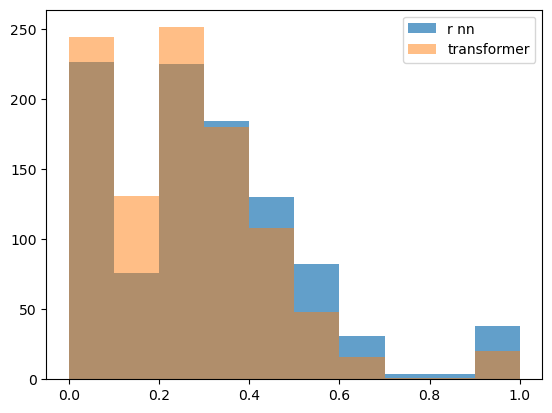

In [109]:
plt.hist(rnn, alpha=0.7, label="r nn")
plt.hist(trans, alpha=0.5, label='transformer')
plt.legend()